## Import necessary libraries

In [9]:

from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import time
from google.colab import drive
import copy
import json
import os
import optuna as optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from sklearn.model_selection import KFold
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import v2
import matplotlib.pyplot as plt


## Check if the environment detect GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())  # Should return True if a GPU is available
!nvidia-smi

True
Thu Sep 12 13:27:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

## Load the data and undergo necessary data augmentation on it

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),         # Flip the image horizontally
        transforms.RandomVerticalFlip(),           # Flip the image vertically
        transforms.RandomRotation(degrees=45),     # Rotate by up to 45 degrees
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Random color jitter
        transforms.RandomGrayscale(p=0.2),         # Convert to grayscale with a probability of 0.2
        transforms.GaussianBlur(kernel_size=5),    # Apply Gaussian Blur
        transforms.ToTensor(),                     # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Mounted at /content/drive
Number of classes: 4
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']


In [4]:
def initialize_model(num_classes):
    # Load the pretrained ResNet50 model
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)


    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Modify the final fully connected layer to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Move the model to the device
    model = model.to(device)

    # Return the model
    return model



In [5]:

# Initialize the optimizer
def initialize_optimizer(model, lr_layer3, lr_layer4, lr_fc, wd_layer3, wd_layer4, wd_fc):
    optimizer = optim.Adam([
        {'params': model.layer3.parameters(), 'lr': lr_layer3, 'weight_decay': wd_layer3},
        {'params': model.layer4.parameters(), 'lr': lr_layer4, 'weight_decay': wd_layer4},
        {'params': model.fc.parameters(), 'lr': lr_fc, 'weight_decay': wd_fc}
    ])
    return optimizer


# Train Model


In [6]:

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, class_names):
    model.to(device)

    train_losses, train_accuracies = [], []
    all_train_preds, all_train_labels = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        epoch_preds, epoch_labels = [], []

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        all_train_preds.extend(epoch_preds)
        all_train_labels.extend(epoch_labels)
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Training Accuracy: {epoch_acc:.4f}')
    # Generate classification report for the entire training set
    train_report = classification_report(all_train_labels, all_train_preds, target_names=class_names, output_dict=True)

    return train_losses, train_accuracies, train_report

def validate_model(model, dataloaders, criterion, device):
    model.to(device)
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(dataloaders['val'].dataset)
    val_acc = val_corrects.double() / len(dataloaders['val'].dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    return val_loss, val_acc.item(), precision, recall, f1, cm
def test_model(model, dataloaders, device):
    model.to(device)
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    test_accuracy = corrects / total
    print(f'Test Accuracy: {test_accuracy:.4f}')

    return test_accuracy


# define optuna to run

In [ ]:
def objective(trial):
    lr_layer3 = trial.suggest_float('lr_layer3', 1e-6, 1e-4,log=True)
    lr_layer4 = trial.suggest_float('lr_layer4', 1e-4, 1e-2,log=True)
    lr_fc = trial.suggest_float('lr_fc', 1e-3, 1e-1,log=True)
    wd_layer3 = trial.suggest_float('wd_layer3', 1e-6, 1e-4,log=True)
    wd_layer4 = trial.suggest_float('wd_layer4', 1e-5, 1e-3,log=True)
    wd_fc = trial.suggest_float('wd_fc', 1e-4, 1e-2,log=True)

    batch_size = 256
    num_epochs = 15

    model = initialize_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(image_datasets['train'])):
        print(f'Fold {fold + 1}/{k_folds}')

        model = initialize_model(num_classes).to(device)
        optimizer = initialize_optimizer(
            model,
            lr_layer3=lr_layer3,  # Trial suggestions
            lr_layer4=lr_layer4,
            lr_fc=lr_fc,
            wd_layer3=wd_layer3,
            wd_layer4=wd_layer4,
            wd_fc=wd_fc
        )

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler)
        valloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=val_sampler)
        dataloaders = {'train': trainloader, 'val': valloader}

        train_losses, train_accuracies = train_model(model, dataloaders, criterion, optimizer, device, num_epochs)
        val_loss, val_accuracy, cm = validate_model(model, dataloaders, criterion, device)
        fold_accuracies.append(val_accuracy)

        trial.report(val_accuracy, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(fold_accuracies)

# Run optuna (Optuna Ran in google colab, will import hyperparameter )


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust number of trials as needed

print('Best trial:')
trial = study.best_trial
print('Value:', trial.value)
print('Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-09-12 12:54:44,994] A new study created in memory with name: no-name-1f391b39-d727-4a87-a1f4-50a203e52229


Fold 1/5


[W 2024-09-12 12:54:45,906] Trial 0 failed with parameters: {'lr_layer3': 9.72933172517799e-06, 'lr_layer4': 0.0008932319628379212, 'lr_fc': 0.010369838388847816, 'wd_layer3': 1.290180069937612e-05, 'wd_layer4': 0.0006264013934016745, 'wd_fc': 0.0006890866857677108} because of the following error: TypeError("train_model() missing 1 required positional argument: 'class_names'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-12-dd0d4ceae0f1>", line 39, in objective
    train_losses, train_accuracies = train_model(model, dataloaders, criterion, optimizer, device, num_epochs)
TypeError: train_model() missing 1 required positional argument: 'class_names'
[W 2024-09-12 12:54:45,907] Trial 0 failed with value None.


TypeError: train_model() missing 1 required positional argument: 'class_names'


# Load HyperParameter got from optune 

In [11]:



file_path = '/content/drive/My Drive/best_hyperparameters.json'

# Load the JSON file
with open(file_path, 'r') as f:
    best_params = json.load(f)

# Display the loaded hyperparameters
print("Loaded Hyperparameters:", best_params)


Loaded Hyperparameters: {'lr_layer3': 4.3537075375038966e-06, 'lr_layer4': 0.0003062100721252667, 'lr_fc': 0.010015403354880308, 'wd_layer3': 7.440856656039355e-06, 'wd_layer4': 1.770804955449013e-05, 'wd_fc': 0.0041248878589996325}


In [12]:
def train_final_model(best_params, class_names):
    model = initialize_model(num_classes).to(device)
    batch_size = 128
    num_epochs = 15

    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    val_precision, val_recall, val_f1 = [], [], []
    confusion_matrices = []
    train_reports = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(image_datasets['train'])):
        print(f'Fold {fold + 1}/{k_folds}')

        model = initialize_model(num_classes).to(device)
        optimizer = optim.Adam([
            {'params': model.layer3.parameters(), 'lr': best_params['lr_layer3'], 'weight_decay': best_params['wd_layer3']},
            {'params': model.layer4.parameters(), 'lr': best_params['lr_layer4'], 'weight_decay': best_params['wd_layer4']},
            {'params': model.fc.parameters(), 'lr': best_params['lr_fc'], 'weight_decay': best_params['wd_fc']}
        ])

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler)
        valloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=val_sampler)
        dataloaders = {'train': trainloader, 'val': valloader}

        fold_train_losses, fold_train_accuracies, fold_train_report = train_model(model, dataloaders, criterion, optimizer, device, num_epochs, class_names)
        fold_val_loss, fold_val_accuracy, fold_val_precision, fold_val_recall, fold_val_f1, cm = validate_model(model, dataloaders, criterion, device)

        train_acc.append(fold_train_accuracies)
        val_acc.append(fold_val_accuracy)
        train_loss.append(fold_train_losses)
        val_loss.append(fold_val_loss)
        val_precision.append(fold_val_precision)
        val_recall.append(fold_val_recall)
        val_f1.append(fold_val_f1)
        confusion_matrices.append(cm)
        train_reports.append(fold_train_report)

        print("Fold {} Training Report:".format(fold + 1))

        print(fold_train_report)


    return model, train_acc, val_acc, train_loss, val_loss, val_precision, val_recall, val_f1, confusion_matrices, train_reports



In [13]:

final_model, train_acc, val_acc, train_loss, val_loss, val_precision, val_recall, val_f1, confusion_matrices, train_reports = train_final_model(best_params, class_names)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Fold 1/5
Epoch 0/14
Training Loss: 1.1081
Training Accuracy: 0.2645
Epoch 1/14
Training Loss: 0.8596
Training Accuracy: 0.4362
Epoch 2/14
Training Loss: 0.7091
Training Accuracy: 0.5005
Epoch 3/14
Training Loss: 0.5892
Training Accuracy: 0.5479
Epoch 4/14
Training Loss: 0.4903
Training Accuracy: 0.6175
Epoch 5/14
Training Loss: 0.4428
Training Accuracy: 0.6291
Epoch 6/14
Training Loss: 0.3649
Training Accuracy: 0.6586
Epoch 7/14
Training Loss: 0.3089
Training Accuracy: 0.6776
Epoch 8/14
Training Loss: 0.2953
Training Accuracy: 0.6997
Epoch 9/14
Training Loss: 0.2519
Training Accuracy: 0.7007
Epoch 10/14
Training Loss: 0.1970
Training Accuracy: 0.7323
Epoch 11/14
Training Loss: 0.2196
Training Accuracy: 0.7060
Epoch 12/14
Training Loss: 0.1809
Training Accuracy: 0.7345
Epoch 13/14
Training Loss: 0.1654
Training Accuracy: 0.7408
Epoch 14/14
Training Loss: 0.1607
Training Accuracy: 0.7450
Validation Loss: 0.1369, Accuracy: 0.1602
Precision: 0.8123, Recall: 0.8000, F1 Score: 0.7973
       

In [14]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss, val_precision, val_recall, val_f1, confusion_matrices, train_reports, class_names):
    folds = len(train_acc)

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Accuracy plot
    axs[0, 0].set_title('Training and Validation Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    for i in range(folds):
        axs[0, 0].plot(train_acc[i], label=f'Train Fold {i+1}')
        axs[0, 0].plot([val_acc[i]]*len(train_acc[i]), linestyle='--', label=f'Val Fold {i+1}')
    axs[0, 0].legend()

    # Loss plot
    axs[0, 1].set_title('Training and Validation Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    for i in range(folds):
        axs[0, 1].plot(train_loss[i], label=f'Train Fold {i+1}')
        axs[0, 1].plot([val_loss[i]]*len(train_loss[i]), linestyle='--', label=f'Val Fold {i+1}')
    axs[0, 1].legend()

    # Validation Precision, Recall, F1 Score
    axs[1, 0].set_title('Validation Precision, Recall, F1 Score')
    x = np.arange(folds)
    width = 0.25
    axs[1, 0].bar(x - width, val_precision, width, label='Precision')
    axs[1, 0].bar(x, val_recall, width, label='Recall')
    axs[1, 0].bar(x + width, val_f1, width, label='F1 Score')
    axs[1, 0].set_xlabel('Fold')
    axs[1, 0].set_ylabel('Score')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels([f'Fold {i+1}' for i in range(folds)])
    axs[1, 0].legend()

    # Training Classification Report Summary
    axs[1, 1].set_title('Training Classification Report Summary')
    axs[1, 1].axis('off')
    for i, report in enumerate(train_reports):
        text = f"Fold {i+1}:\n"
        for class_name in class_names:
            text += f"{class_name}: F1={report[class_name]['f1-score']:.2f}, "
        text += f"\nOverall: F1={report['weighted avg']['f1-score']:.2f}\n\n"
        axs[1, 1].text(0, 1-i*0.2, text, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for each fold
    for i, cm in enumerate(confusion_matrices):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for Fold {i+1}')
        plt.show()

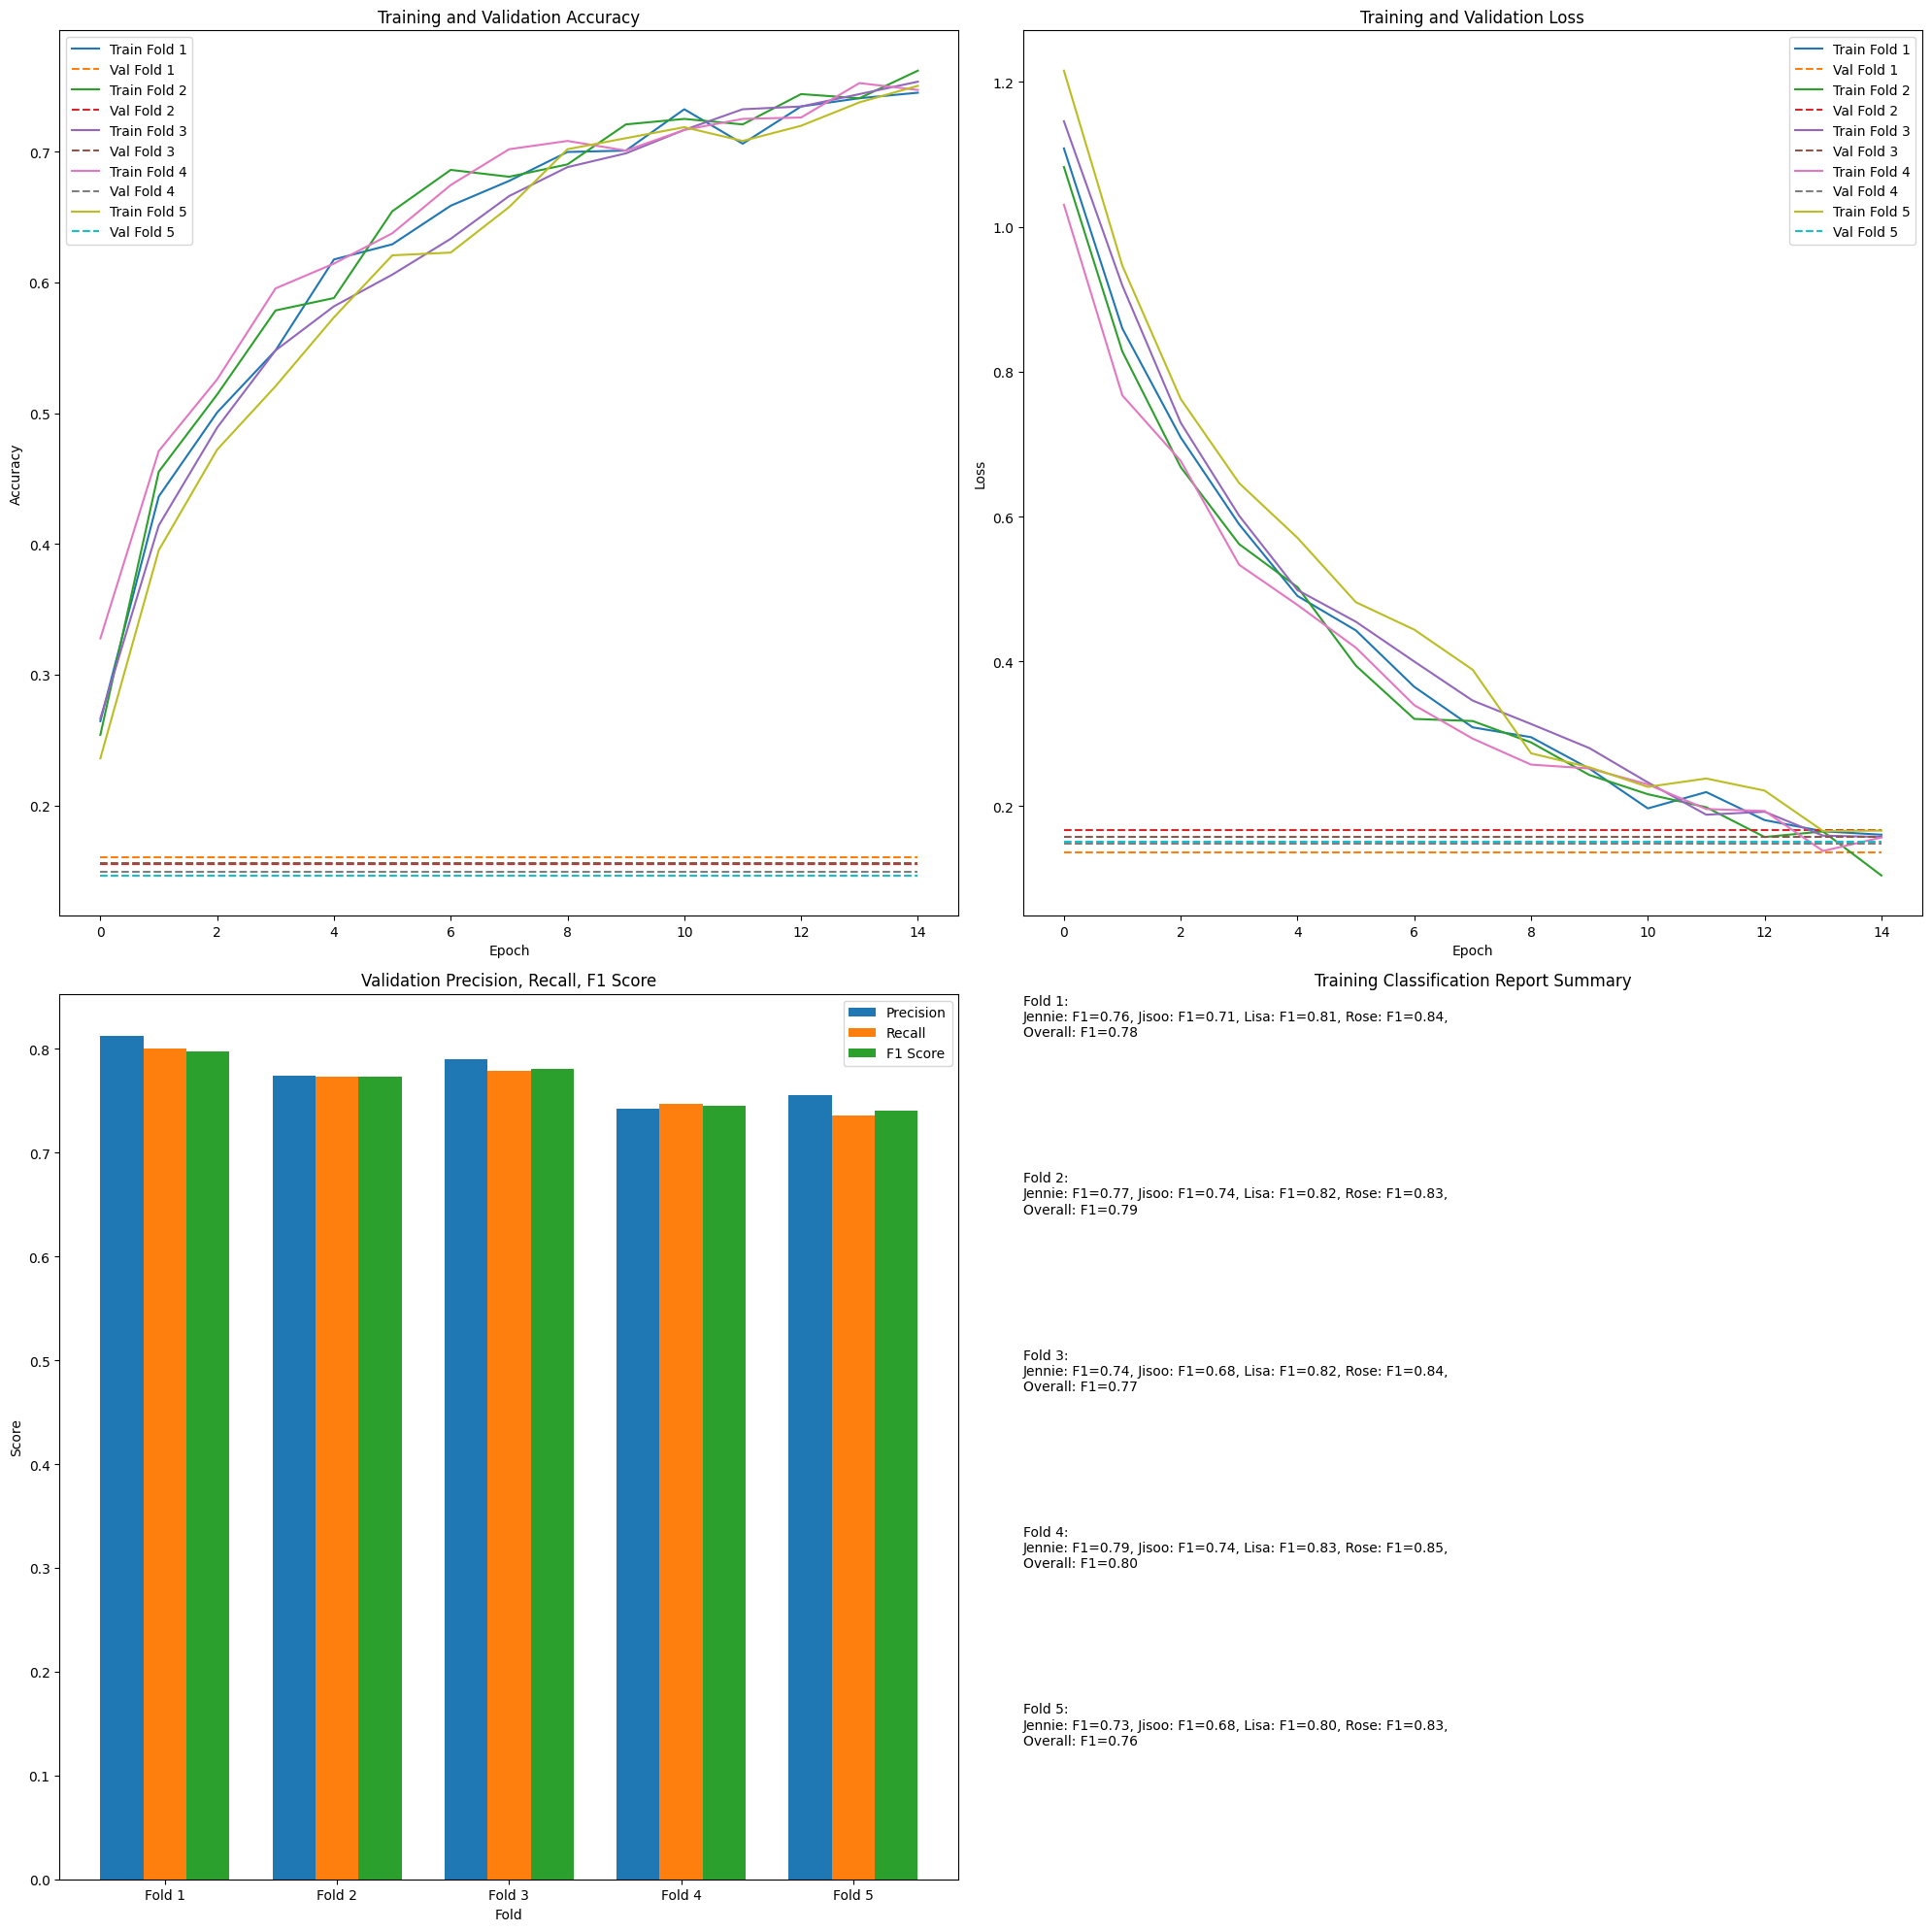

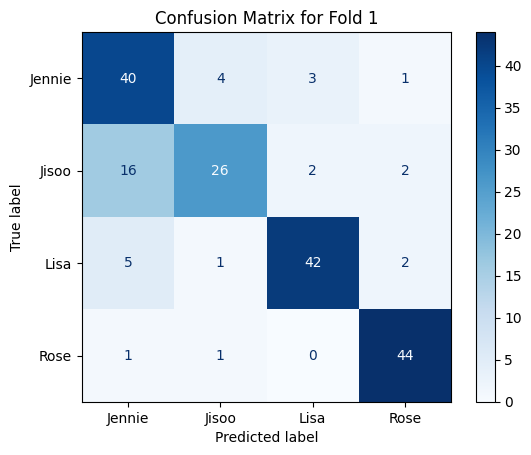

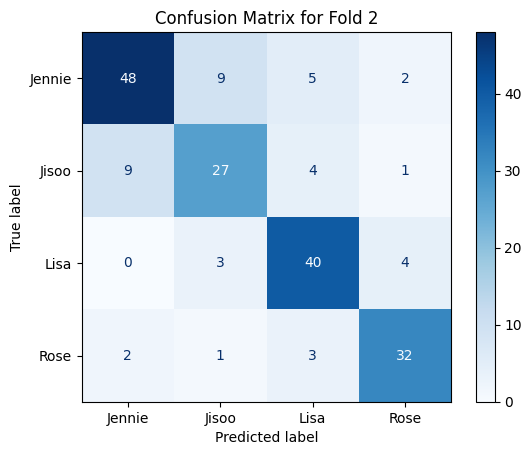

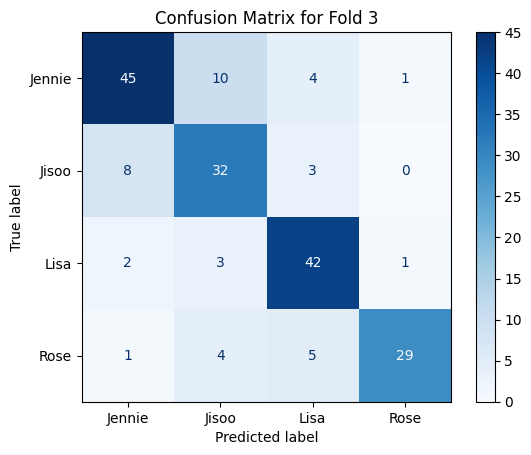

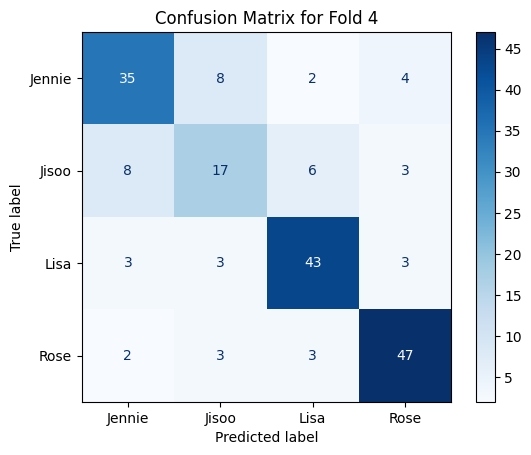

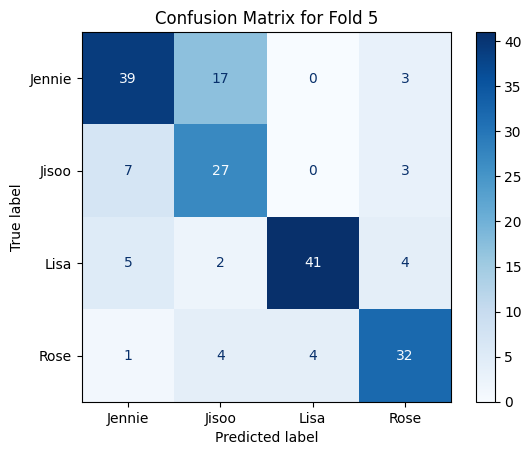

In [15]:
plot_metrics(train_acc, val_acc, train_loss, val_loss, val_precision, val_recall, val_f1, confusion_matrices, train_reports, class_names)

In [18]:
# Create test dataloader
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=128, shuffle=False)
dataloaders={'test':test_loader}

# Test the final model
test_accuracy = test_model(final_model, dataloaders, device)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7243
Final Test Accuracy: 0.7243


In [20]:
torch.save(final_model.state_dict(), '/content/drive/My Drive/model.pth')
